# Train a Quantum GAN

**Poblem Statement:** Train a Quantum GAN that has a quantum generator and a quantum discriminator to learn one-qubit quantum state.



What we need?

**True Data**: A cirucit that can prepare the given one-qubit state

**Quantum Generator**: A PQC that represents the quantum generator

**Discriminator**: A PQC that represents the quantum discriminator

In [ ]:
# installations
from IPython.display import clear_output
!pip install torch pennylane
clear_output()

In [ ]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# set seed for reproducibility
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

## Prepare True Quantum State


We use the U3 universal gate to prepare any required single qubit state just by setting the values for $\theta$, $\phi$, and $\delta$.

$$
U_3(\theta, \phi, \delta) =
\begin{bmatrix}
\cos\left(\frac{\theta}{2}\right) & -e^{i\delta} \sin\left(\frac{\theta}{2}\right) \\
e^{i\phi} \sin\left(\frac{\theta}{2}\right) & e^{i(\phi + \delta)} \cos\left(\frac{\theta}{2}\right)
\end{bmatrix}
$$


In [ ]:
# set the param values
phi = np.pi/3
theta = np.pi/4
delta = np.pi/5
def prepare_true_state():
  qml.U3(theta, phi, delta, wires=0)

(<Figure size 400x200 with 1 Axes>, <Axes: >)

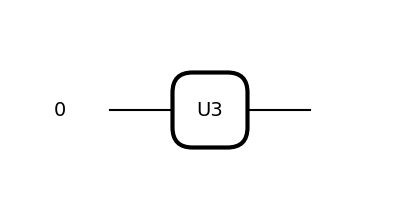

In [ ]:
# visualize the generator
qml.draw_mpl(prepare_true_state)()

## Define the Generator

For the generator, we use a single U3 gate in the circuit and initialize random values for $\phi$, $\theta$, and $\delta$. Therefore, the generator has 3 weights.

In [ ]:
# variational form of generator
def GeneratorVF(weights):
  qml.U3(weights[0], weights[1], weights[2], wires=0)

In [ ]:
def Generator(weights):
  GeneratorVF(weights)

(<Figure size 400x200 with 1 Axes>, <Axes: >)

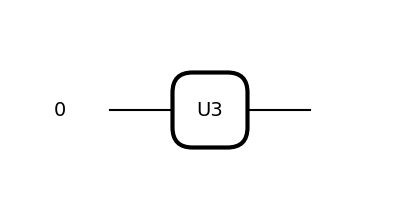

In [ ]:
# visualize the generator
qml.draw_mpl(Generator)([0.0, 0.0, 0.0])

## Define the discriminator

For the discriminator, we use two-local form PQC. The number of weights in the discriminator are `(repetitions+1) * num_qubits * num_gate_layers `.

In [ ]:
def DiscriminatorVF(weights, num_qubits, repetitions=3):
  num_param = 0
  for rep in range(repetitions):

    # add variational layers
    for qubit in range(num_qubits):
      qml.RX(weights[num_param],wires=qubit)
      num_param+=1
      qml.RY(weights[num_param],wires=qubit)
      num_param+=1
      qml.RY(weights[num_param],wires=qubit)
      num_param+=1

    # add entanglement block
    for cx_qubit in range(num_qubits-1):
      qml.CNOT(wires=[cx_qubit, cx_qubit+1])

  # add final variational block
  for qubit in range(num_qubits):
    qml.RX(weights[num_param],wires=qubit)
    num_param+=1
    qml.RY(weights[num_param],wires=qubit)
    num_param+=1
    qml.RY(weights[num_param],wires=qubit)
    num_param+=1

In [ ]:
num_qubits = 2
num_repetitions = 3
def Discriminator(weights):
  DiscriminatorVF(weights, num_qubits=num_qubits, repetitions=num_repetitions)

(<Figure size 1800x300 with 1 Axes>, <Axes: >)

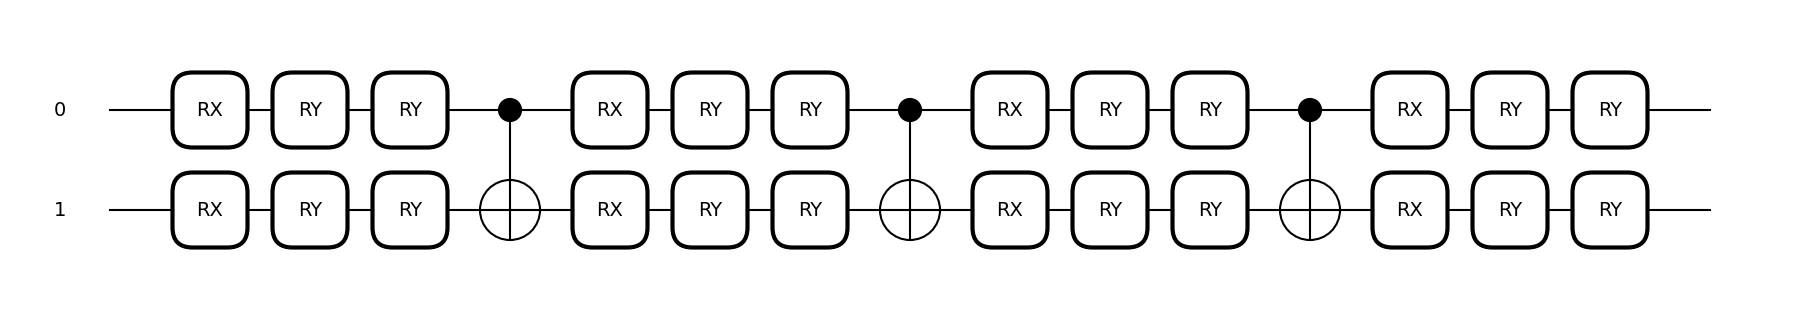

In [ ]:
sample_weights = torch.rand((num_repetitions+1)*num_qubits*3)
qml.draw_mpl(Discriminator)(sample_weights)

## Construct QNodes for Generator and Discriminator

In [ ]:
ket_0 = [[1],[0]]
Measurement = ket_0 * np.conj(ket_0).T

In [ ]:
device = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(device,interface='torch', diff_method="parameter-shift")
def discriminator_with_true_data(weights_discriminator):
  prepare_true_state()
  Discriminator(weights_discriminator)
  return qml.expval(qml.Hermitian(Measurement, wires=[0]))


In [ ]:
@qml.qnode(device,interface='torch', diff_method="parameter-shift")
def discriminator_with_generated_data(weights_generator,weights_discriminator):
  Generator(weights_generator)
  Discriminator(weights_discriminator)
  return qml.expval(qml.Hermitian(Measurement, wires=[0]))

(<Figure size 1900x300 with 1 Axes>, <Axes: >)

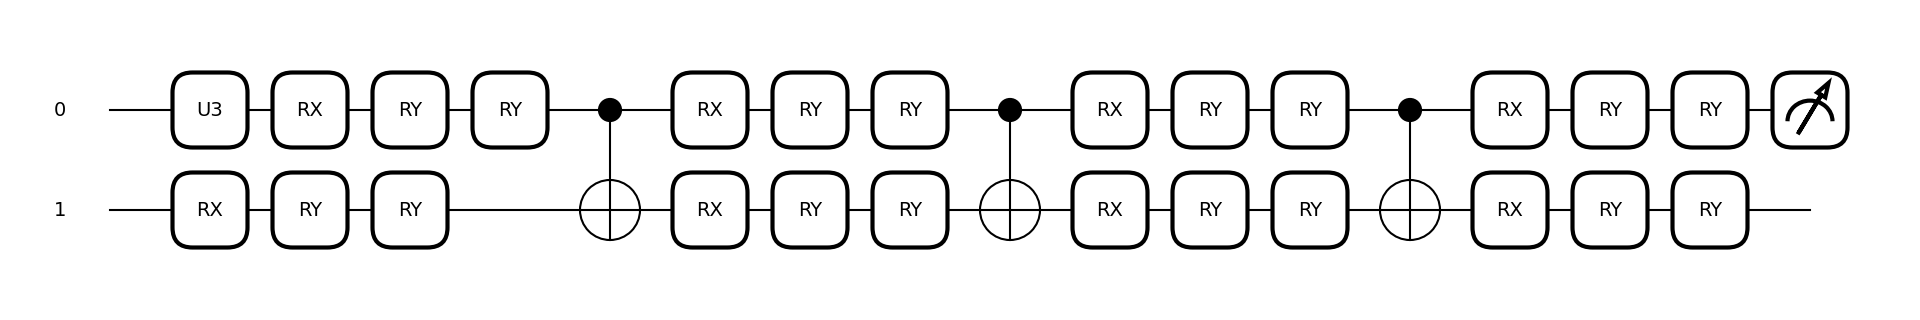

In [ ]:
# true data circuit
qml.draw_mpl(discriminator_with_true_data)(sample_weights)

(<Figure size 1900x300 with 1 Axes>, <Axes: >)

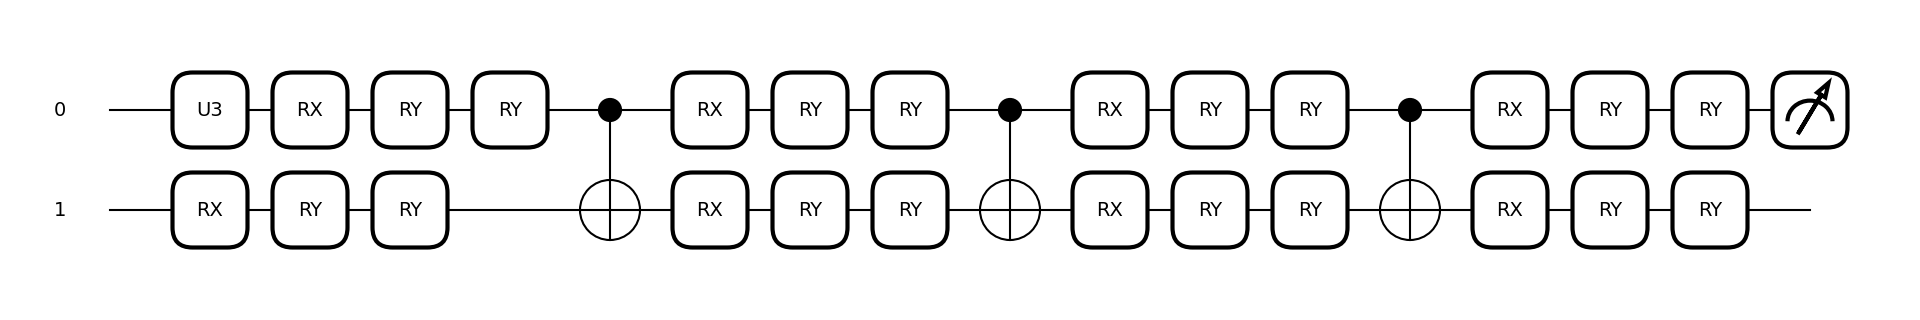

In [ ]:
# true data circuit
qml.draw_mpl(discriminator_with_generated_data)([0,0,0],sample_weights)

## Training Loop

$ L_D = -\frac{1}{2} \left( log (1 - D(|\psi_g >)) + log(D(|\psi_t>)) \right) $

$ L_G = -log(D(\psi_g)) $

$ | \psi_g > $ = state generated by Generator

$ | \psi_t > $ = true state


In [ ]:
def discriminator_loss(weights_generator, weights_discriminator):
  discriminator_fake_output = discriminator_with_generated_data(weights_generator,weights_discriminator)
  discriminator_true_output = discriminator_with_true_data(weights_discriminator)
  return -(torch.log(1-discriminator_fake_output) - torch.log(discriminator_true_output))/2

In [ ]:
def generator_loss(weights_generator, weights_discriminator):
  discriminator_fake_output = discriminator_with_generated_data(weights_generator,weights_discriminator)
  return -torch.log(discriminator_fake_output)

In [ ]:
# initialize weights
weights_generator = torch.rand(3, requires_grad=True)
weights_discriminator = torch.rand((num_repetitions+1)*num_qubits*3, requires_grad=True)

In [ ]:
# initialize optimizers
opt_g = torch.optim.SGD([weights_generator], lr=0.5)
opt_d = torch.optim.SGD([weights_discriminator], lr=0.5)

In [ ]:
discriminator_losses = []
generator_losses = []

num_training_cycles = 200
for i in range(num_training_cycles):

  opt_d.zero_grad()
  loss_discriminator = discriminator_loss(weights_generator, weights_discriminator)
  loss_discriminator.backward()
  opt_d.step()

  opt_g.zero_grad()
  loss_generator = generator_loss(weights_generator, weights_discriminator)
  loss_generator.backward()
  opt_g.step()

  discriminator_losses.append(loss_discriminator.item())
  generator_losses.append(loss_generator.item())

  if (i+1)%20 == 0:
    print("Epoch:", i+1, end="")
    print(" || Discriminator Loss:", loss_discriminator.item(), end="")
    print(" || Generator Loss:", loss_generator.item())


Epoch: 20 || Discriminator Loss: -1.1681997487736189 || Generator Loss: 1.046165004966019
Epoch: 40 || Discriminator Loss: 0.17809301231490623 || Generator Loss: 1.4263314559619602
Epoch: 60 || Discriminator Loss: -0.05180525411491971 || Generator Loss: 1.722742054756745
Epoch: 80 || Discriminator Loss: -0.12236768300159806 || Generator Loss: 2.9044891941516884
Epoch: 100 || Discriminator Loss: 0.4926281577402712 || Generator Loss: 1.19186805198284
Epoch: 120 || Discriminator Loss: -0.10453938910488458 || Generator Loss: 1.7208402213423974
Epoch: 140 || Discriminator Loss: -0.08521300972780504 || Generator Loss: 1.769182623957523
Epoch: 160 || Discriminator Loss: -0.5872994182441145 || Generator Loss: 1.363210954086568
Epoch: 180 || Discriminator Loss: -1.0822777415501894 || Generator Loss: 1.4325594462931812
Epoch: 200 || Discriminator Loss: -0.2240044537394491 || Generator Loss: 1.4288275813175022


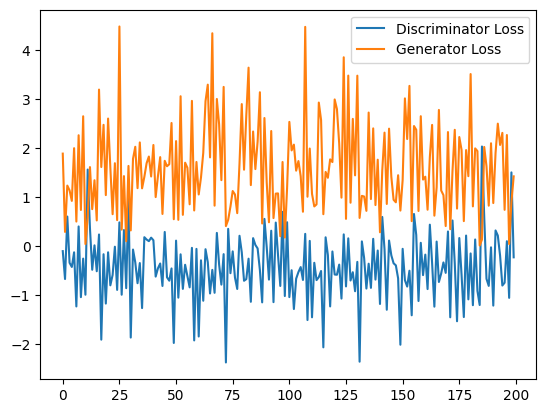

In [ ]:
plt.plot(discriminator_losses, label="Discriminator Loss")
plt.plot(generator_losses, label="Generator Loss")
plt.legend()
plt.show()

## References

1. A practical guide to Qua